In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
df=pd.read_csv("https://raw.githubusercontent.com/bbaigalaa/Predict-energy-consumption/master/dataset/2012_2013_merged_customerID_11.csv", 
               parse_dates=["date"],
               index_col="date")

In [ ]:
df.head()

,temperature,apparentTemperature,precipIntensity,precipProbability,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,uvIndex,cloudCover,visibility,GC
date,,,,,,,,,,,,,,
2012-07-01 00:30:00,10.77,10.77,0.0,0.0,5.48,0.70,1014.8,0.75,0.75,294,0,0.78,9.988,0.567
2012-07-01 01:00:00,10.21,10.21,0.0,0.0,5.52,0.73,0.0,0.21,0.61,289,0,1.00,0.000,0.547
2012-07-01 01:30:00,10.21,10.21,0.0,0.0,5.52,0.73,0.0,0.21,0.61,289,0,1.00,0.000,0.613
2012-07-01 02:00:00,9.48,9.48,0.0,0.0,5.22,0.75,0.0,0.33,0.95,284,0,0.88,0.000,0.519
2012-07-01 02:30:00,9.48,9.48,0.0,0.0,5.22,0.75,0.0,0.33,0.95,284,0,0.88,0.000,0.314


# 1. ARIMA

Dropping all features, except GC.

In [ ]:
columns=["temperature","apparentTemperature","precipIntensity","precipProbability","dewPoint","humidity", "pressure",	"windSpeed","windGust","windBearing","uvIndex","cloudCover","visibility"]
df.drop(columns=columns, inplace=True)

In [ ]:
df.head()

,GC
date,
2012-07-01 00:30:00,0.567
2012-07-01 01:00:00,0.547
2012-07-01 01:30:00,0.613
2012-07-01 02:00:00,0.519
2012-07-01 02:30:00,0.314


In [ ]:

df.index = pd.DatetimeIndex(df.index)

In [ ]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
fig = go.Figure(
    data = go.Scatter(
        x = df.index, 
        y = df["GC"],
        mode="lines"
    ),
    layout = go.Layout(
        title = go.layout.Title(text = "Energy consumption over year", x = 0.5),
        xaxis = go.layout.XAxis(title = 'Time'),
        yaxis = go.layout.YAxis(title = 'Consumption[kWh]')
    )
)

fig.show()

### Augmented Dickey-Fuller test

*  Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent tructure.
*  Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [ ]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()

*  p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
*  p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

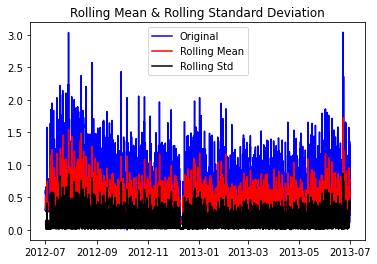

In [ ]:
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

The rolling mean and rolling standard deviation increase with time. 

In [ ]:
result = adfuller(df['GC'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -13.452808206923804
p-value: 3.6559308629536047e-25
Critical Values:
	1%: -3.4307242852745428
	5%: -2.8617054196196627
	10%: -2.566858048572343


p-value is way too small.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in log



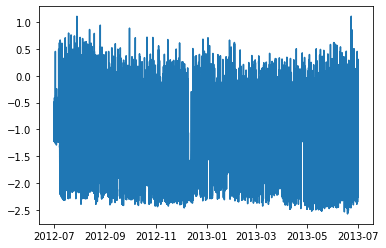

In [ ]:
# df_log = np.log(df)
df_log = np.log(df)
df_log[df_log==-np.inf]=0
plt.plot(df_log)

### Checking if the data is stationay or not

In [ ]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['GC'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

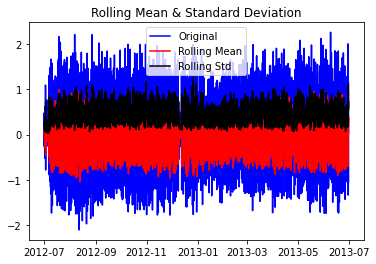

ADF Statistic: -38.7314944404935
p-value: 0.0
Critical Values:
	1%: -3.430724521072713
	5%: -2.861705523826764
	10%: -2.5668581040402207


In [ ]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

Time series is definately **stationary**

In [ ]:
df.isna().sum()

GC    0
dtype: int64

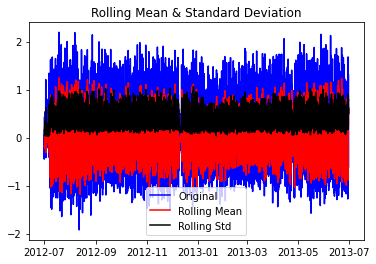

ADF Statistic: -23.130223861296866
p-value: 0.0
Critical Values:
	1%: -3.4307242852745428
	5%: -2.8617054196196627
	10%: -2.566858048572343


In [ ]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)

get_stationarity(df_log_exp_decay)
#If there is missing value it should not execute.

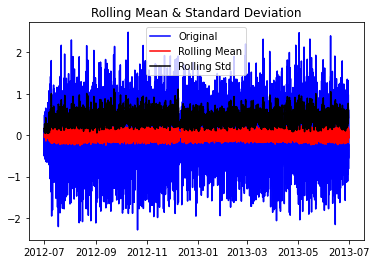

ADF Statistic: -52.2190952851544
p-value: 0.0
Critical Values:
	1%: -3.43072430669847
	5%: -2.861705429087613
	10%: -2.566858053611991


In [ ]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [ ]:
decomposition = seasonal_decompose(df_log, freq=1) 
model = ARIMA(df_log, order=(1,1,2))
results = model.fit(disp=-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



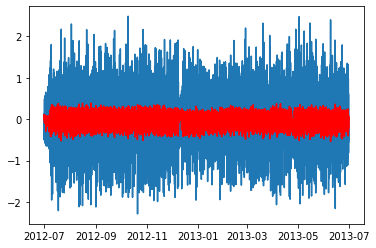

In [ ]:
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

In [ ]:
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D.GC   No. Observations:                17518
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -10393.865
Method:                       css-mle   S.D. of innovations              0.438
Date:                Tue, 25 Aug 2020   AIC                          20797.729
Time:                        02:45:04   BIC                          20836.584
Sample:                             1   HQIC                         20810.524
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.077e-05   1.52e-05     -0.710      0.478   -4.05e-05     1.9e-05
ar.L1.D.GC     0.8472      0.005    164.189      0.000       0.837       0.857
ma.L1.D.GC    -1.1165      0.010   -110.663      0.0

In [ ]:
# 1,1,1 ARIMA Model
model = ARIMA(df_log, order=(1,1,1))
results = model.fit(disp=0)
print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                             ARIMA Model Results                              
Dep. Variable:                   D.GC   No. Observations:                17518
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10464.630
Method:                       css-mle   S.D. of innovations              0.440
Date:                Tue, 25 Aug 2020   AIC                          20937.261
Time:                        02:46:51   BIC                          20968.345
Sample:                             1   HQIC                         20947.496
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.039e-05   1.72e-05     -0.603      0.547   -4.42e-05    2.34e-05
ar.L1.D.GC     0.8064      0.005    178.699      0.000       0.798       0.815
ma.L1.D.GC    -0.9991      0.000  -2733.925      0.0

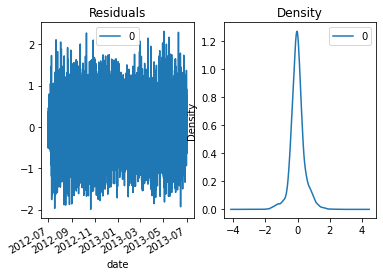

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

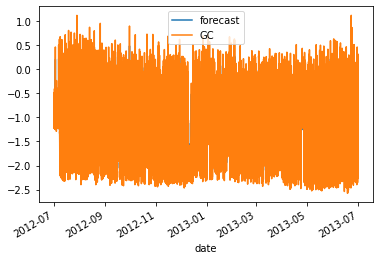

In [ ]:
# Actual vs Fitted
results.plot_predict(dynamic=False)
plt.show()

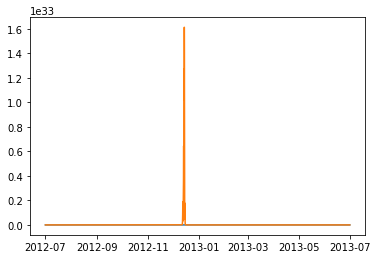

In [ ]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['GC'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

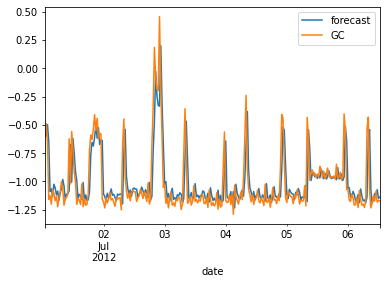

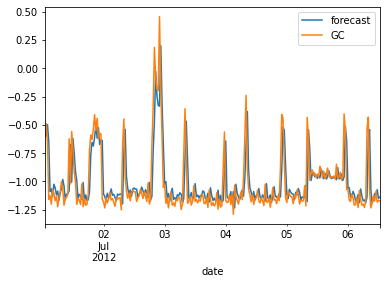

In [ ]:
results.plot_predict(1,264)
